In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gdown
import kagglehub
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor

# Helper Functions

In [2]:
def fetch_dataset(key, dataset_name):
    cmd = !gdown --fuzzy {key} -O {dataset_name}
    path = pd.Series(cmd).str.extractall(r'(To.*)').reset_index()[0].iloc[0].split(': ')[1]
    print(f'{dataset_name} path: {path}')
    return path

def get_null_percentage(df):
    null_series = ((df.isnull().sum()/len(df))*100).sort_values()
    return null_series

def generate_time_features(df):
    df = df.reset_index()
    df.loc[:,'day']  = df['Order Date'].dt.day
    df.loc[:,'month']  = df['Order Date'].dt.month
    df.loc[:,'year']  = df['Order Date'].dt.year
    df.loc[:,'is_weekend']  = df['Order Date'].dt.weekday > 5
    df.loc[:,'day_of_week']  = df['Order Date'].dt.day_of_week
    df.loc[:,'day_of_year']  = df['Order Date'].dt.day_of_year
    df.loc[:,'quarter']  = df['Order Date'].dt.quarter
    df.loc[:,'is_month_start']  = df['Order Date'].dt.is_month_start
    df.loc[:,'is_month_end']  = df['Order Date'].dt.is_month_end
    df.loc[:,'is_year_start']  = df['Order Date'].dt.is_year_start
    df.loc[:,'is_year_end']  = df['Order Date'].dt.is_year_end
    df = df.set_index('Order Date')
    return df

def add_holidays_past_2021(df):

    _2022 = pd.Series(['2022-12-26', '2022-11-24', '2022-11-11', '2022-10-10', '2022-09-05', '2022-07-04', '2022-06-20', '2022-05-30', '2022-02-21', '2022-01-21', '2023-01-02', '2023-01-16', '2023-02-20']) 
    
    _2022 = pd.to_datetime(_2022)
    dates = pd.Series(['January 02 2023',
    'January 16 2023',
    'February 20 2023',
    'May 29 2023',
    'June 19 2023',
    'July 04 2023',
    'September 04 2023',
    'October 09 2023',
    'November 10 2023',
    'November 23 2023',
    'December 25 2023',
    'January 01 2024',
    'January 15 2024',
    'February 19 2024',
    'May 27 2024',
    'June 19 2024',
    'July 04 2024',
    'September 02 2024',	
    'October 14 2024',
    'November 11 2024',	
    'November 28 2024',	
    'December 25 2024',
    'January 01 2025',
    'January 20 2025',
    'January 20 2025',
    'February 17 2025',
    'May 26 2025',
    'June 19 2025',
    'July 04 2025',
    'September 01 2025',	
    'October 13 2025',
    'November 11 2025',
    'November 27 2025',
    'December 25 2025',
    'January 01 2026',
    'January 19 2026',
    'February 16 2026',
    'May 25 2026',
    'June 19 2026',
    'July 03 2026',
    'September 07 2025',
    'October 12 2026',
    'November 11 2026',
    'November 26 2026',
    'December 25 2026'
                      ])
    fedral_holidays_2023_plus = pd.to_datetime(dates)
    fedral_holdidays_22_plus = pd.concat([_2022, fedral_holidays_2023_plus], axis=0).sort_values()
    fedral_holdidays_22_plus = pd.Series(fedral_holdidays_22_plus.unique())
    fedral_holdidays_22_plus.index = range(len(fedral_holdidays_22_plus))
    fedral_holdidays_22_plus = pd.DataFrame(fedral_holdidays_22_plus).rename(columns={0:'date'})
    fedral_holdidays_22_plus['fedral_holiday'] = True
    fedral_holdidays_22_plus = fedral_holdidays_22_plus.set_index('date')
    return pd.merge(df, fedral_holdidays_22_plus, how='left', left_index = True, right_index=True)

def add_events(events_timestamps, is_repeat=False):
    dummy_date = '2017-04-10'
    events = pd.DatetimeIndex([dummy_date])
    if is_repeat:
        for i in range(len([2018,2019,2020,2021,2022,2023,2024,2025,2026])):
            events = events.append(pd.date_range(start=events_timestamps[0], end=events_timestamps[1]) \
                                   + pd.tseries.offsets.DateOffset(months=i*12))
    else:
        for event in events_timestamps:
            events = events.append(pd.date_range(start=event[0], end=event[1]))
    return events[1:]

def assign_historic_sales(df, year_till=2022):
    df = df.reset_index()
    sales = df[['Order Date', 'total_sales']]
    sales = sales.set_index('Order Date')
    past_sales = list(sales[sales.index.year <= year_till]['total_sales'])
    lag = [np.nan] * (len(sales) - len(past_sales))
    lag.extend(past_sales)
    lag = pd.Series(lag, index=sales.index)
    df = df.set_index('Order Date')
    return lag

def add_amazon_events(df):
    global amazon_events_df
    df = pd.merge(df, amazon_events_df, left_index=True, right_index=True, how='left')
    df['Amazon Events'] = df['Amazon Events'].fillna('No Events')
    df = pd.get_dummies(df, drop_first=True)
    return df

# Dataset imports

In [3]:
path = fetch_dataset("1HdJj68eO9NTZlpwZcLYqdtPqrbKs1cxj", "amazon_purchases.csv")
purchases = pd.read_csv(path)
purchases = purchases[purchases['Shipping Address State'].notnull()]
purchases.rename(columns={'ASIN/ISBN (Product Code)': 'product_code'}, inplace=True)

path = kagglehub.dataset_download("donnetew/us-holiday-dates-2004-2021")
holidays = pd.read_csv(os.path.join(path,'US Holiday Dates (2004-2021).csv'))
holidays['is_holiday'] = True
holidays['Date'] = pd.to_datetime(holidays['Date'])
holidays.set_index('Date', inplace=True)

path = fetch_dataset("19167R4OV0GWNiCHTh3w9T07616S91enj", "amazon_categories.csv")
categories = pd.read_csv(path)

path = fetch_dataset("1yoaKl-7wctxH315gH_M15fS5WERnFlHe", "amazon_products.csv")
products = pd.read_csv(path)
products = products.rename(columns={'asin':'product_code'})

amazon_purchases.csv path: C:\Users\rohit\5010\project\AmazonSalesPredictor\amazon_purchases.csv
amazon_categories.csv path: C:\Users\rohit\5010\project\AmazonSalesPredictor\amazon_categories.csv
amazon_products.csv path: C:\Users\rohit\5010\project\AmazonSalesPredictor\amazon_products.csv


## Data Cleaning

In [4]:
products = pd.merge(products, categories, how='inner', left_on='category_id', right_on='id').drop('id', axis=1)
product_codes_category_null = purchases[purchases['Category'].isnull()]['product_code']

data_replacements = products[products['product_code'].isin(product_codes_category_null.unique())][['product_code','title','category_name']]

purchases = pd.merge(purchases, data_replacements, on='product_code', how='left')

purchases.loc[(purchases['Category'].isnull())&(purchases['category_name'].notnull()), 'Category'] = purchases.loc[(purchases['Category'].isnull())&(purchases['category_name'].notnull()), 'category_name']

purchases.loc[(purchases['Title'].isnull()) & (purchases['title'].notnull()), 'Title'] = purchases.loc[(purchases['Title'].isnull()) & (purchases['title'].notnull()), 'title']
purchases.drop(['title', 'category_name'], axis=1, inplace=True)
purchases.dropna(axis=0,subset= ['Shipping Address State','Category'], inplace=True)

In [6]:
get_null_percentage(purchases)

Order Date                 0.000000
Purchase Price Per Unit    0.000000
Quantity                   0.000000
Shipping Address State     0.000000
Survey ResponseID          0.000000
Category                   0.000000
product_code               0.016695
Title                      0.033391
dtype: float64

In [7]:
purchases

,Order Date,Purchase Price Per Unit,Quantity,Shipping Address State,Title,product_code,Category,Survey ResponseID
0,2018-12-04,7.98,1.0,NJ,SanDisk Ultra 16GB Class 10 SDHC UHS-I Memory ...,B0143RTB1E,FLASH_MEMORY,R_01vNIayewjIIKMF
1,2018-12-22,13.99,1.0,NJ,Betron BS10 Earphones Wired Headphones in Ear ...,B01MA1MJ6H,HEADPHONES,R_01vNIayewjIIKMF
3,2018-12-25,10.45,1.0,NJ,Perfecto Stainless Steel Shaving Bowl. Durable...,B06XWF9HML,DISHWARE_BOWL,R_01vNIayewjIIKMF
4,2018-12-25,10.00,1.0,NJ,Proraso Shaving Cream for Men,B00837ZOI0,SHAVING_AGENT,R_01vNIayewjIIKMF
5,2019-02-18,10.99,1.0,NJ,Micro USB Cable Android Charger - Syncwire [2-...,B01GFB2E9M,COMPUTER_PROCESSOR,R_01vNIayewjIIKMF
...,...,...,...,...,...,...,...,...
1762900,2021-04-01,20.75,1.0,MA,50 Feather (Yellow Label) Razor Blades Platinu...,B08P5K9GMJ,RAZOR_BLADE_CARTRIDGE,R_zfqnsBzlOAKibzb
1762901,2021-04-01,6.99,1.0,MA,Tanner's Tasty Paste Vanilla Bling - Anticavit...,B015ZRTHVA,TOOTH_CLEANING_AGENT,R_zfqnsBzlOAKibzb
1762902,2021-04-14,15.99,1.0,MA,Sinland Microfiber Cleaning Cloth Dish Cloth K...,B00QGCXPRG,TOWEL,R_zfqnsBzlOAKibzb
1762903,2021-05-22,6.99,4.0,MA,Tanner's Tasty Paste Vanilla Bling - Anticavit...,B015ZRTHVA,TOOTH_CLEANING_AGENT,R_zfqnsBzlOAKibzb


# Feature engineering

In [9]:
purchases['Order Date'] = pd.to_datetime(purchases['Order Date'])
purchases.set_index('Order Date', inplace=True)
purchases = purchases[purchases.index.year<2023]
purchases.loc[:,'total_sales'] = purchases['Purchase Price Per Unit'] * purchases['Quantity']

C:\Users\rohit\AppData\Local\Temp\ipykernel_46208\2163439034.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases.loc[:,'total_sales'] = purchases['Purchase Price Per Unit'] * purchases['Quantity']


In [10]:
df = purchases.copy()
df = pd.DataFrame(df.groupby(df.index)['total_sales'].sum())

**Add time features**

In [11]:
df = generate_time_features(df)

In [12]:
df

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,is_year_start,is_year_end
Order Date,,,,,,,,,,,,
2018-01-01,13758.87,1,1,2018,False,0,1,1,True,False,True,False
2018-01-02,15264.69,2,1,2018,False,1,2,1,False,False,False,False
2018-01-03,10929.09,3,1,2018,False,2,3,1,False,False,False,False
2018-01-04,14426.91,4,1,2018,False,3,4,1,False,False,False,False
2018-01-05,16119.67,5,1,2018,False,4,5,1,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,19553.68,27,12,2022,False,1,361,4,False,False,False,False
2022-12-28,16831.29,28,12,2022,False,2,362,4,False,False,False,False
2022-12-29,18275.91,29,12,2022,False,3,363,4,False,False,False,False


**Add amazon events**

In [13]:
amazon_events = add_events([['2024-03-20', '2024-03-25'], ['2025-03-25', '2025-03-31']])
spring_sale_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':['Big Spring Sale']*len(amazon_events)}).set_index('Event Date')

In [14]:
amazon_events = add_events([
    ['2018-07-16', '2018-07-17'],
    ['2019-07-15', '2019-07-16'],
    ['2020-10-13', '2020-10-14'],
    ['2021-06-21', '2021-06-22'],
    ['2022-07-12', '2022-07-13'],
    ['2023-07-11', '2023-07-12'],
    ['2024-07-16', '2024-07-17'],
    ['2025-07-23', '2025-07-24']
])
prime_day_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':['Amazon Prime Day']*len(amazon_events)}).set_index('Event Date')

In [15]:
amazon_events = add_events([
    ['2022-10-11', '2022-10-12'],  
    ['2023-10-10', '2023-10-11'],  
    ['2024-10-08', '2024-10-09'],
    ['2025-10-14', '2025-10-15']
])
prime_big_deal_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':['Prime Big Deal Days']*len(amazon_events)}).set_index('Event Date')

In [16]:
amazon_events = add_events([
    ['2018-11-16', '2018-11-23'],
    ['2019-11-22', '2019-11-29'],
    ['2020-11-20', '2020-11-27'],
    ['2021-11-19', '2021-11-26'],
    ['2022-11-24', '2022-11-25'],
    ['2023-11-17', '2023-11-24'],
    ['2024-11-21', '2024-11-29'],
    ['2025-11-28', '2025-12-01']
]
)
black_friday_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':['Black Friday']*len(amazon_events)}).set_index('Event Date')

In [17]:
amazon_events = add_events([
    ['2018-02-05', '2018-02-14'],
    ['2019-02-04', '2019-02-14'],
    ['2020-02-03', '2020-02-14'],
    ['2021-02-01', '2021-02-14'],
    ['2022-02-03', '2022-02-10'],
    ['2023-02-04', '2023-02-14'],
    ['2024-02-02', '2024-02-14'],
    ['2025-02-02', '2025-02-14']
])
valentines_day_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':["Valentine's Day Promotions"]*len(amazon_events)}).set_index('Event Date')

In [18]:
amazon_events = add_events([
    ['2018-05-01', '2018-05-13'],
    ['2019-05-03', '2019-05-12'],
    ['2020-05-01', '2020-05-10'],
    ['2021-05-01', '2021-05-09'],
    ['2022-05-03', '2022-05-09'],
    ['2023-05-01', '2023-05-14'],
    ['2024-05-02', '2024-05-12'],
    ['2025-05-06', '2025-05-12']
])
mothers_day_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':["Mother's Day Deals"]*len(amazon_events)}).set_index('Event Date')

In [19]:
amazon_events = add_events([
    ['2018-05-25', '2018-05-28'],
    ['2019-05-24', '2019-05-27'],
    ['2020-05-22', '2020-05-25'],
    ['2021-05-28', '2021-05-31'],
    ['2022-05-27', '2022-05-30'],
    ['2023-05-26', '2023-05-29'],
    ['2024-05-24', '2024-05-27'],
    ['2025-05-23', '2025-05-26']
])
memorial_day_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':["Memorial Day Sales"]*len(amazon_events)}).set_index('Event Date')

In [20]:
amazon_events = add_events(('2018-12-02', '2018-12-13'), is_repeat=True)
_12_day_of_deals_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':['12 Days of Deals']*len(amazon_events)}).set_index('Event Date')

In [21]:
amazon_events = add_events(('2018-12-25', '2019-01-01'), is_repeat=True)
year_end_clearance_event_df = pd.DataFrame({'Event Date':amazon_events,'Amazon Events':['Year-End Clearance Sale']*len(amazon_events)}).set_index('Event Date')

**concat**

In [22]:
amazon_events_df = pd.concat([spring_sale_event_df,prime_day_event_df,prime_big_deal_event_df,black_friday_event_df,valentines_day_event_df,mothers_day_event_df,memorial_day_event_df,_12_day_of_deals_event_df,year_end_clearance_event_df], axis=0).sort_index()

In [23]:
amazon_events_df

,Amazon Events
Event Date,
2018-02-05,Valentine's Day Promotions
2018-02-06,Valentine's Day Promotions
2018-02-07,Valentine's Day Promotions
2018-02-08,Valentine's Day Promotions
2018-02-09,Valentine's Day Promotions
...,...
2026-12-28,Year-End Clearance Sale
2026-12-29,Year-End Clearance Sale
2026-12-30,Year-End Clearance Sale


Text(0.5, 0, 'Amazon events in 2018')

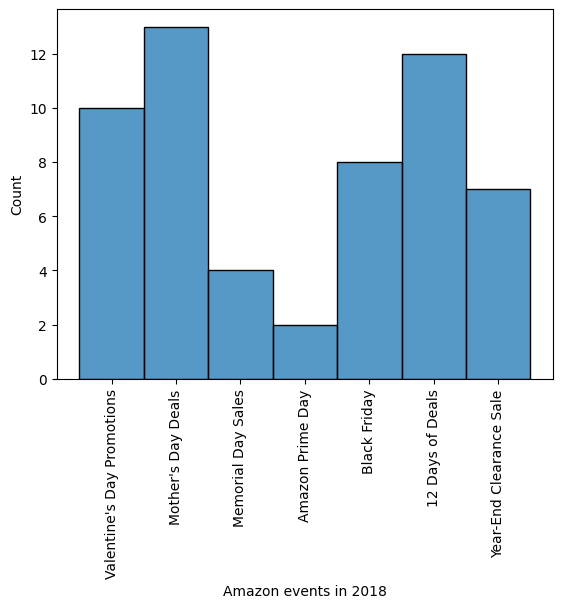

In [24]:
sns.histplot(amazon_events_df[amazon_events_df.index.year==2018], x='Amazon Events')
plt.xticks(rotation=90);
plt.xlabel('Amazon events in 2018')

Text(0.5, 0, 'Amazon events yearly')

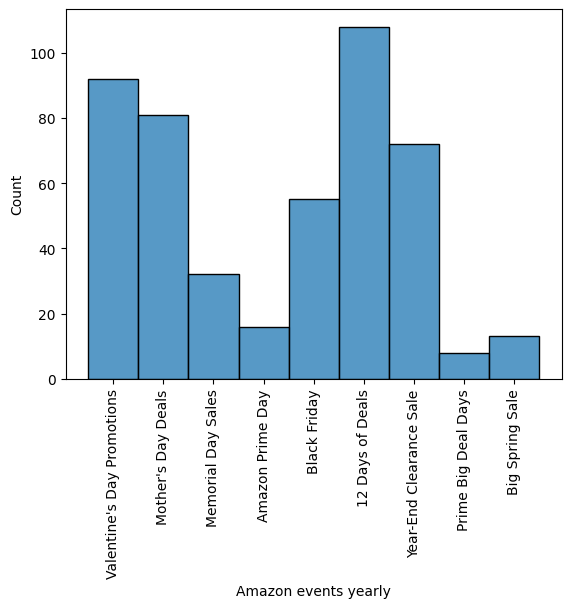

In [25]:
sns.histplot(amazon_events_df, x='Amazon Events')
plt.xticks(rotation=90);
plt.xlabel('Amazon events yearly')

In [26]:
df = pd.merge(df, amazon_events_df, left_index=True, right_index=True, how='left')

In [27]:
df['Amazon Events'].value_counts()

Amazon Events
12 Days of Deals              60
Valentine's Day Promotions    55
Mother's Day Deals            49
Year-End Clearance Sale       39
Black Friday                  34
Memorial Day Sales            20
Amazon Prime Day              10
Prime Big Deal Days            2
Name: count, dtype: int64

In [28]:
df['Amazon Events'] = df['Amazon Events'].fillna('No Events')

Text(0.5, 0, 'Amazon events in 2022')

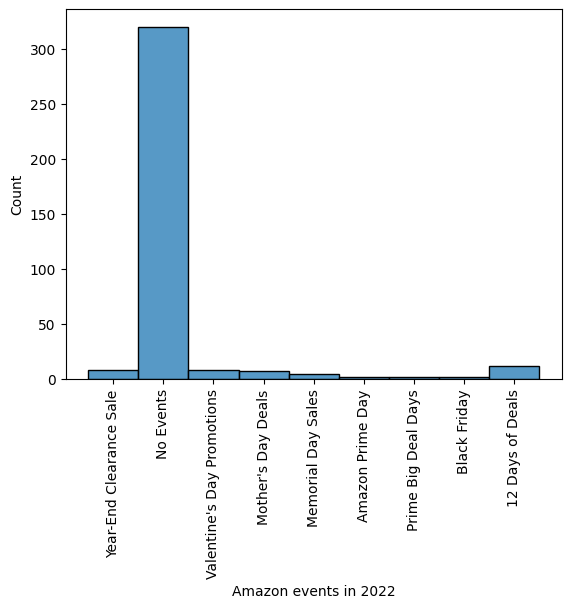

In [29]:
sns.histplot(df[df.index.year==2022], x='Amazon Events')
plt.xticks(rotation=90);
plt.xlabel('Amazon events in 2022')

In [30]:
df = pd.get_dummies(df, drop_first=True)

In [31]:
df

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,is_year_start,is_year_end,Amazon Events_Amazon Prime Day,Amazon Events_Black Friday,Amazon Events_Memorial Day Sales,Amazon Events_Mother's Day Deals,Amazon Events_No Events,Amazon Events_Prime Big Deal Days,Amazon Events_Valentine's Day Promotions,Amazon Events_Year-End Clearance Sale
Order Date,,,,,,,,,,,,,,,,,,,,
2018-01-01,13758.87,1,1,2018,False,0,1,1,True,False,True,False,False,False,False,False,True,False,False,False
2018-01-02,15264.69,2,1,2018,False,1,2,1,False,False,False,False,False,False,False,False,True,False,False,False
2018-01-03,10929.09,3,1,2018,False,2,3,1,False,False,False,False,False,False,False,False,True,False,False,False
2018-01-04,14426.91,4,1,2018,False,3,4,1,False,False,False,False,False,False,False,False,True,False,False,False
2018-01-05,16119.67,5,1,2018,False,4,5,1,False,False,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,19553.68,27,12,2022,False,1,361,4,False,False,False,False,False,False,False,False,False,False,False,True
2022-12-28,16831.29,28,12,2022,False,2,362,4,False,False,False,False,False,False,False,False,False,False,False,True
2022-12-29,18275.91,29,12,2022,False,3,363,4,False,False,False,False,False,False,False,False,False,False,False,True


**Add holidays**

In [32]:
df = pd.merge(df, holidays['is_holiday'], how='left', left_index=True, right_index=True)
df = add_holidays_past_2021(df)
df['fedral_holiday'] = df['is_holiday'].fillna(False) + df['fedral_holiday'].fillna(False)
df.drop('is_holiday', axis=1,inplace= True)

C:\Users\rohit\AppData\Local\Temp\ipykernel_46208\3289957183.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['fedral_holiday'] = df['is_holiday'].fillna(False) + df['fedral_holiday'].fillna(False)


In [33]:
df['fedral_holiday'].value_counts()

fedral_holiday
False    1740
True       86
Name: count, dtype: int64

**Add inflation**

In [34]:
df = pd.merge(df, inflation_df, left_index=True, right_index=True, how='left')
df['inflation_rate'] = df['inflation_rate'].interpolate()

NameError: name 'inflation_df' is not defined

In [35]:
df

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,...,is_year_end,Amazon Events_Amazon Prime Day,Amazon Events_Black Friday,Amazon Events_Memorial Day Sales,Amazon Events_Mother's Day Deals,Amazon Events_No Events,Amazon Events_Prime Big Deal Days,Amazon Events_Valentine's Day Promotions,Amazon Events_Year-End Clearance Sale,fedral_holiday
Order Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,13758.87,1,1,2018,False,0,1,1,True,False,...,False,False,False,False,False,True,False,False,False,True
2018-01-02,15264.69,2,1,2018,False,1,2,1,False,False,...,False,False,False,False,False,True,False,False,False,False
2018-01-03,10929.09,3,1,2018,False,2,3,1,False,False,...,False,False,False,False,False,True,False,False,False,False
2018-01-04,14426.91,4,1,2018,False,3,4,1,False,False,...,False,False,False,False,False,True,False,False,False,False
2018-01-05,16119.67,5,1,2018,False,4,5,1,False,False,...,False,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,19553.68,27,12,2022,False,1,361,4,False,False,...,False,False,False,False,False,False,False,False,True,False
2022-12-28,16831.29,28,12,2022,False,2,362,4,False,False,...,False,False,False,False,False,False,False,False,True,False
2022-12-29,18275.91,29,12,2022,False,3,363,4,False,False,...,False,False,False,False,False,False,False,False,True,False


**Add historic overall sales**

In [36]:
df['Sales 1YA'] = assign_historic_sales(df, year_till=2021)
df['Sales 2YA'] = assign_historic_sales(df, year_till=2020)
df['Sales 3YA'] = assign_historic_sales(df, year_till=2019)

In [37]:
df

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,...,Amazon Events_Memorial Day Sales,Amazon Events_Mother's Day Deals,Amazon Events_No Events,Amazon Events_Prime Big Deal Days,Amazon Events_Valentine's Day Promotions,Amazon Events_Year-End Clearance Sale,fedral_holiday,Sales 1YA,Sales 2YA,Sales 3YA
Order Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,13758.87,1,1,2018,False,0,1,1,True,False,...,False,False,True,False,False,False,True,NaN,NaN,NaN
2018-01-02,15264.69,2,1,2018,False,1,2,1,False,False,...,False,False,True,False,False,False,False,NaN,NaN,NaN
2018-01-03,10929.09,3,1,2018,False,2,3,1,False,False,...,False,False,True,False,False,False,False,NaN,NaN,NaN
2018-01-04,14426.91,4,1,2018,False,3,4,1,False,False,...,False,False,True,False,False,False,False,NaN,NaN,NaN
2018-01-05,16119.67,5,1,2018,False,4,5,1,False,False,...,False,False,True,False,False,False,False,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,19553.68,27,12,2022,False,1,361,4,False,False,...,False,False,False,False,False,True,False,32394.22,25753.28,17074.32
2022-12-28,16831.29,28,12,2022,False,2,362,4,False,False,...,False,False,False,False,False,True,False,27670.93,26604.36,17281.64
2022-12-29,18275.91,29,12,2022,False,3,363,4,False,False,...,False,False,False,False,False,True,False,31239.59,29159.44,18194.65


**Add historic state-wise sales**

In [38]:
def get_shift_value(year, forcast_df=None):
    global df
    if forcast_df is None:
        return (df[df.index.year<2023].index[-1] - df[df.index.year<=year].index[-1]).days
    else:
        return (forcast_df.index[-1] - df[df.index.year<=year].index[-1]).days

In [39]:
def add_states_lags():
    global purchases, df
    temp_df = purchases[['Shipping Address State','Category','total_sales']]
    
    temp_df = pd.DataFrame(temp_df.groupby([temp_df.index,'Shipping Address State'])['total_sales'].sum()).reset_index()
    
    states_features = pd.pivot( temp_df[['Order Date', 'Shipping Address State', 'total_sales']], index='Order Date', columns='Shipping Address State', values='total_sales').reset_index().fillna(0)
    
    states_features = states_features.set_index('Order Date')

    scaler = MinMaxScaler()

    scaled_data = scaler.fit_transform(states_features)
    
    pca = PCA(n_components=3,random_state=101)
    
    pca_features = pca.fit_transform(scaled_data)

    state_sales_reduced = pd.DataFrame(pca_features)

    state_sales_reduced.rename(columns={0:'SS1',1:'SS2',2:'SS3'}, inplace=True)

    state_sales_reduced.set_index(df.index, inplace=True)

    states_features = pd.concat([state_sales_reduced, state_sales_reduced.shift(get_shift_value(2021)-10).rename(columns={'SS1':'SS1 1YA','SS2':'SS2 1YA','SS3':'SS3 1YA'}), state_sales_reduced.shift(get_shift_value(2020)-10).rename(columns={'SS1':'SS1 2YA','SS2':'SS2 2YA','SS3':'SS3 2YA'}), state_sales_reduced.shift(get_shift_value(2019)-10).rename(columns={'SS1':'SS1 3YA','SS2':'SS2 3YA','SS3':'SS3 3YA'})], axis=1)

    return pd.merge(df, states_features, left_index=True, right_index=True, how='left')

In [40]:
get_shift_value(2020)-1

729

In [41]:
df = add_states_lags()

In [54]:
df.columns

Index(['total_sales', 'day', 'month', 'year', 'is_weekend', 'day_of_week',
       'day_of_year', 'quarter', 'is_month_start', 'is_month_end',
       'is_year_start', 'is_year_end', 'Amazon Events_Amazon Prime Day',
       'Amazon Events_Black Friday', 'Amazon Events_Memorial Day Sales',
       'Amazon Events_Mother's Day Deals', 'Amazon Events_No Events',
       'Amazon Events_Prime Big Deal Days',
       'Amazon Events_Valentine's Day Promotions',
       'Amazon Events_Year-End Clearance Sale', 'fedral_holiday', 'Sales 1YA',
       'Sales 2YA', 'Sales 3YA', 'SS1', 'SS2', 'SS3', 'SS1 1YA', 'SS2 1YA',
       'SS3 1YA', 'SS1 2YA', 'SS2 2YA', 'SS3 2YA', 'SS1 3YA', 'SS2 3YA',
       'SS3 3YA'],
      dtype='object')

## Cross Validation

**generate forcast dataframe**

In [43]:
feature_columns = list(df.columns)
[feature_columns.remove(column) for column in ['total_sales','SS1','SS2','SS3']]
feature_columns

['day',
 'month',
 'year',
 'is_weekend',
 'day_of_week',
 'day_of_year',
 'quarter',
 'is_month_start',
 'is_month_end',
 'is_year_start',
 'is_year_end',
 'Amazon Events_Amazon Prime Day',
 'Amazon Events_Black Friday',
 'Amazon Events_Memorial Day Sales',
 "Amazon Events_Mother's Day Deals",
 'Amazon Events_No Events',
 'Amazon Events_Prime Big Deal Days',
 "Amazon Events_Valentine's Day Promotions",
 'Amazon Events_Year-End Clearance Sale',
 'fedral_holiday',
 'Sales 1YA',
 'Sales 2YA',
 'Sales 3YA',
 'SS1 1YA',
 'SS2 1YA',
 'SS3 1YA',
 'SS1 2YA',
 'SS2 2YA',
 'SS3 2YA',
 'SS1 3YA',
 'SS2 3YA',
 'SS3 3YA']

In [55]:
forcast_df =  pd.DataFrame(pd.date_range('2023-01-01', '2023-12-31'),columns=['Order Date'])

In [56]:
forcast_df = generate_time_features(forcast_df)

In [57]:
forcast_df = add_holidays_past_2021(forcast_df)

In [58]:
forcast_df['fedral_holiday'] = forcast_df['fedral_holiday'].fillna(False)

C:\Users\rohit\AppData\Local\Temp\ipykernel_46208\2162938522.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  forcast_df['fedral_holiday'] = forcast_df['fedral_holiday'].fillna(False)


In [59]:
forcast_df = add_amazon_events(forcast_df)

In [60]:
forcast_df = forcast_df.drop('index',axis=1)

In [66]:
df.columns

Index(['total_sales', 'day', 'month', 'year', 'is_weekend', 'day_of_week',
       'day_of_year', 'quarter', 'is_month_start', 'is_month_end',
       'is_year_start', 'is_year_end', 'Amazon Events_Amazon Prime Day',
       'Amazon Events_Black Friday', 'Amazon Events_Memorial Day Sales',
       'Amazon Events_Mother's Day Deals', 'Amazon Events_No Events',
       'Amazon Events_Prime Big Deal Days',
       'Amazon Events_Valentine's Day Promotions',
       'Amazon Events_Year-End Clearance Sale', 'fedral_holiday', 'Sales 1YA',
       'Sales 2YA', 'Sales 3YA', 'SS1', 'SS2', 'SS3', 'SS1 1YA', 'SS2 1YA',
       'SS3 1YA', 'SS1 2YA', 'SS2 2YA', 'SS3 2YA', 'SS1 3YA', 'SS2 3YA',
       'SS3 3YA', 'forcasting'],
      dtype='object')

In [65]:
forcast_df

,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,is_year_start,...,fedral_holiday,Amazon Events_Amazon Prime Day,Amazon Events_Black Friday,Amazon Events_Memorial Day Sales,Amazon Events_Mother's Day Deals,Amazon Events_No Events,Amazon Events_Prime Big Deal Days,Amazon Events_Valentine's Day Promotions,Amazon Events_Year-End Clearance Sale,forcasting
Order Date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,1,1,2023,True,6,1,1,True,False,True,...,False,False,False,False,False,False,False,False,True,True
2023-01-02,2,1,2023,False,0,2,1,False,False,False,...,True,False,False,False,False,True,False,False,False,True
2023-01-03,3,1,2023,False,1,3,1,False,False,False,...,False,False,False,False,False,True,False,False,False,True
2023-01-04,4,1,2023,False,2,4,1,False,False,False,...,False,False,False,False,False,True,False,False,False,True
2023-01-05,5,1,2023,False,3,5,1,False,False,False,...,False,False,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,27,12,2023,False,2,361,4,False,False,False,...,False,False,False,False,False,False,False,False,True,True
2023-12-28,28,12,2023,False,3,362,4,False,False,False,...,False,False,False,False,False,False,False,False,True,True
2023-12-29,29,12,2023,False,4,363,4,False,False,False,...,False,False,False,False,False,False,False,False,True,True


In [63]:
forcast_df['forcasting'] = True
df['forcasting'] = False

pd.concat([df, forcast_df], axis=0)

,total_sales,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,...,SS1 1YA,SS2 1YA,SS3 1YA,SS1 2YA,SS2 2YA,SS3 2YA,SS1 3YA,SS2 3YA,SS3 3YA,forcasting
Order Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,13758.87,1,1,2018,False,0,1,1,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2018-01-02,15264.69,2,1,2018,False,1,2,1,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2018-01-03,10929.09,3,1,2018,False,2,3,1,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2018-01-04,14426.91,4,1,2018,False,3,4,1,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2018-01-05,16119.67,5,1,2018,False,4,5,1,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,NaN,27,12,2023,False,2,361,4,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-12-28,NaN,28,12,2023,False,3,362,4,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
2023-12-29,NaN,29,12,2023,False,4,363,4,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [51]:
forcast_df['forcasting'] = True
df['forcasting'] = False

combined_df = pd.concat([df, forcast_df], axis=0)

combined_df['Sales 1YA'] = assign_historic_sales(combined_df, year_till=2022)
combined_df['Sales 2YA'] = assign_historic_sales(combined_df, year_till=2021)
combined_df['Sales 3YA'] = assign_historic_sales(combined_df, year_till=2020)

combined_df[['SS1 1YA','SS2 1YA','SS3 1YA']] = combined_df[['SS1','SS2','SS3']].shift(get_shift_value(2022, forcast_df)-10)
combined_df[['SS1 2YA','SS2 2YA','SS3 2YA']] = combined_df[['SS1','SS2','SS3']].shift(get_shift_value(2021, forcast_df)-10)
combined_df[['SS1 3YA','SS2 3YA','SS3 3YA']] = combined_df[['SS1','SS2','SS3']].shift(get_shift_value(2020, forcast_df)-10)

forcast_df[['Sales 1YA', 'Sales 2YA', 'Sales 3YA','SS1 1YA','SS2 1YA','SS3 1YA','SS1 2YA','SS2 2YA','SS3 2YA','SS1 3YA','SS2 3YA','SS3 3YA']] = combined_df[combined_df['forcasting'] == True][['Sales 1YA', 'Sales 2YA', 'Sales 3YA','SS1 1YA','SS2 1YA','SS3 1YA','SS1 2YA','SS2 2YA','SS3 2YA','SS1 3YA','SS2 3YA','SS3 3YA']]

forcast_df = forcast_df.drop('forcasting',axis=1)
df = df.drop('forcasting',axis=1)

In [46]:
forcast_df['inflation_rate'] = df['inflation_rate'].mean()

In [47]:
forcast_df = pd.concat([df[sorted(feature_columns)].iloc[-30:],forcast_df[sorted(feature_columns)]], axis=0)

In [48]:
forcast_df = forcast_df[feature_columns]

In [49]:
forcast_df

,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,is_year_start,...,Sales 3YA,SS1 1YA,SS2 1YA,SS3 1YA,SS1 2YA,SS2 2YA,SS3 2YA,SS1 3YA,SS2 3YA,SS3 3YA
Order Date,,,,,,,,,,,,,,,,,,,,,
2022-12-02,2,12,2022,False,4,336,4,False,False,False,...,68580.09,0.390799,-0.084732,0.011374,0.528721,0.111993,-0.014622,0.316070,-0.053215,-0.196227
2022-12-03,3,12,2022,False,5,337,4,False,False,False,...,19426.56,0.589301,-0.070354,-0.148633,0.501165,-0.168356,-0.163615,0.318811,-0.110406,-0.109510
2022-12-04,4,12,2022,True,6,338,4,False,False,False,...,21674.11,0.575905,0.002422,0.037183,0.500846,-0.035116,0.207645,0.312876,0.071322,-0.069005
2022-12-05,5,12,2022,False,0,339,4,False,False,False,...,22322.26,0.781905,0.041588,0.295036,0.476775,0.043697,-0.068057,0.351064,0.116608,-0.166644
2022-12-06,6,12,2022,False,1,340,4,False,False,False,...,24400.10,0.687362,-0.216649,0.221436,0.674633,-0.046609,0.088321,0.400270,0.047092,-0.143028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,27,12,2023,False,2,361,4,False,False,False,...,28083.85,NaN,NaN,NaN,-0.039552,-0.065894,0.009674,0.076311,0.101759,0.266981
2023-12-28,28,12,2023,False,3,362,4,False,False,False,...,28408.56,NaN,NaN,NaN,0.146726,-0.065005,0.080304,0.056957,-0.014689,-0.005521
2023-12-29,29,12,2023,False,4,363,4,False,False,False,...,30703.10,NaN,NaN,NaN,0.105093,-0.020891,0.066558,0.058295,-0.075090,-0.017525


In [50]:
df[feature_columns]

,day,month,year,is_weekend,day_of_week,day_of_year,quarter,is_month_start,is_month_end,is_year_start,...,Sales 3YA,SS1 1YA,SS2 1YA,SS3 1YA,SS1 2YA,SS2 2YA,SS3 2YA,SS1 3YA,SS2 3YA,SS3 3YA
Order Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,1,1,2018,False,0,1,1,True,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,2,1,2018,False,1,2,1,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-03,3,1,2018,False,2,3,1,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-04,4,1,2018,False,3,4,1,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,5,1,2018,False,4,5,1,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,27,12,2022,False,1,361,4,False,False,False,...,18605.45,-0.039552,-0.065894,0.009674,0.076311,0.101759,0.266981,-0.066376,-0.165988,-0.427192
2022-12-28,28,12,2022,False,2,362,4,False,False,False,...,18191.95,0.146726,-0.065005,0.080304,0.056957,-0.014689,-0.005521,-0.199835,-0.027518,-0.055484
2022-12-29,29,12,2022,False,3,363,4,False,False,False,...,19580.33,0.105093,-0.020891,0.066558,0.058295,-0.075090,-0.017525,-0.119714,-0.040575,-0.076681


**cross validate**

In [63]:

def cross_validate(df, forcastdf, feature_columns):
    scores = []
    preds = []
    feature_importances = []
    sales = []
    tss = TimeSeriesSplit(n_splits=3, test_size=365, gap=0)
    feature_columns = sorted(feature_columns)
    for train_idx, val_idx in tss.split(df):
        scaler = StandardScaler()
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        X_train = train[feature_columns]
        y_train = train['total_sales']
        X_test = test[feature_columns]
        y_test = test['total_sales']
        reg_model = xgb.XGBRegressor(base_score=0.5, booster='gblinear',  n_estimators=1000, early_stopping_rounds=50, objective='reg:squarederror', learning_rate=0.01)
        reg_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)
        feature_importances.append(reg_model.feature_importances_)
        y_preds = reg_model.predict(X_train)
        score = np.sqrt(mean_squared_error(y_train, y_preds))
        print('train: ',score)
        ds =  pd.concat([y_train.reset_index(),pd.Series(y_preds)], axis=1)
        ds = ds.set_index('Order Date')
        ds['total_sales'].plot(label='true data')
        ds[0].plot(label='prediction')
        plt.legend()
        plt.show()
        y_preds = reg_model.predict(X_test)
        ds =  pd.concat([y_test.reset_index(),pd.Series(y_preds)], axis=1)
        ds = ds.set_index('Order Date')
        ds['total_sales'].plot(label='true data')
        ds[0].plot(label='prediction')
        plt.legend()
        plt.show()
        forcast_preds = reg_model.predict(forcastdf[feature_columns])
        ds =  pd.Series(forcast_preds, index=forcastdf.index)
        ds.plot(label='prediction')
        plt.legend()
        plt.show()
        
        preds.append(y_preds)
        score = np.sqrt(mean_squared_error(y_test, y_preds))
        print('test: ',score)
        scores.append(score)

    return preds, scores, feature_importances

[0]	validation_0-rmse:15773.12435	validation_1-rmse:24082.54581
[1]	validation_0-rmse:14644.53557	validation_1-rmse:22582.94054
[2]	validation_0-rmse:13630.30460	validation_1-rmse:21242.01755
[3]	validation_0-rmse:12727.35105	validation_1-rmse:20035.12264
[4]	validation_0-rmse:11921.98803	validation_1-rmse:18952.01791
[5]	validation_0-rmse:11206.49705	validation_1-rmse:17982.78357
[6]	validation_0-rmse:10571.74960	validation_1-rmse:17114.77973
[7]	validation_0-rmse:10010.12190	validation_1-rmse:16338.02709
[8]	validation_0-rmse:9515.33951	validation_1-rmse:15643.83948
[9]	validation_0-rmse:9080.72154	validation_1-rmse:15023.92883
[10]	validation_0-rmse:8699.27999	validation_1-rmse:14469.41524
[11]	validation_0-rmse:8365.77566	validation_1-rmse:13974.60362
[12]	validation_0-rmse:8075.06711	validation_1-rmse:13532.98368
[13]	validation_0-rmse:7821.45835	validation_1-rmse:13138.66172
[14]	validation_0-rmse:7600.54724	validation_1-rmse:12785.54042
[15]	validation_0-rmse:7408.86522	validati

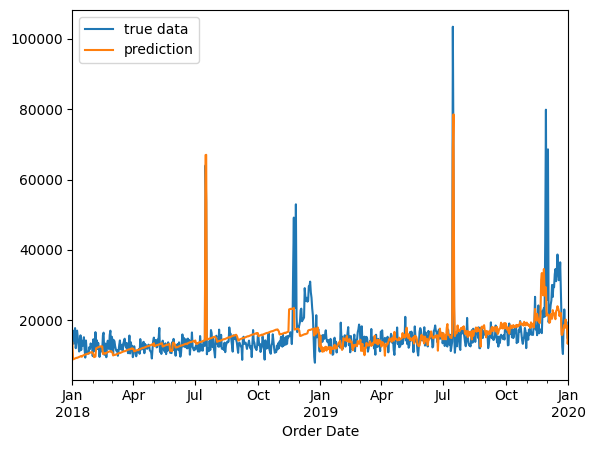

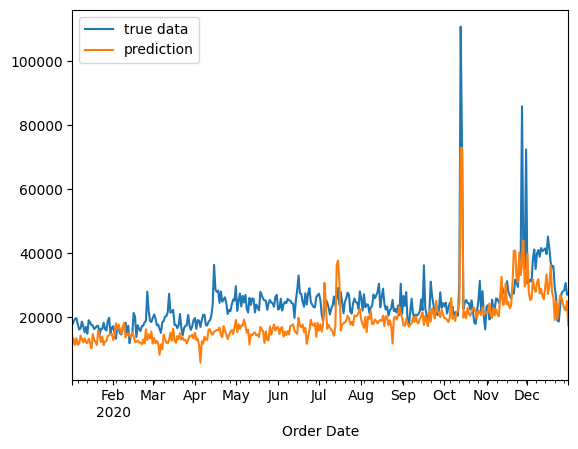

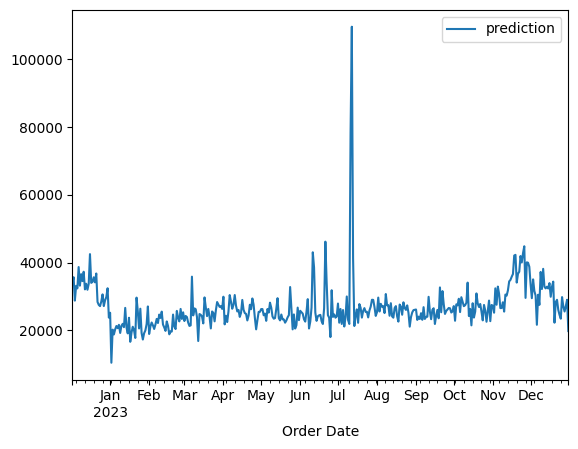

test:  8017.401470366139
[0]	validation_0-rmse:18694.34209	validation_1-rmse:28253.28934
[1]	validation_0-rmse:17215.96010	validation_1-rmse:26239.07934
[2]	validation_0-rmse:15898.23126	validation_1-rmse:24435.49594
[3]	validation_0-rmse:14726.59248	validation_1-rmse:22824.80915
[4]	validation_0-rmse:13689.05717	validation_1-rmse:21395.72698
[5]	validation_0-rmse:12772.78323	validation_1-rmse:20134.64684
[6]	validation_0-rmse:11965.87493	validation_1-rmse:19006.29089
[7]	validation_0-rmse:11258.55948	validation_1-rmse:18014.97356
[8]	validation_0-rmse:10640.18936	validation_1-rmse:17137.45763
[9]	validation_0-rmse:10099.74939	validation_1-rmse:16361.40029
[10]	validation_0-rmse:9630.52425	validation_1-rmse:15673.62939
[11]	validation_0-rmse:9223.23801	validation_1-rmse:15065.53965
[12]	validation_0-rmse:8871.62084	validation_1-rmse:14532.18790
[13]	validation_0-rmse:8567.73860	validation_1-rmse:14061.06004
[14]	validation_0-rmse:8305.88180	validation_1-rmse:13645.49932
[15]	validation

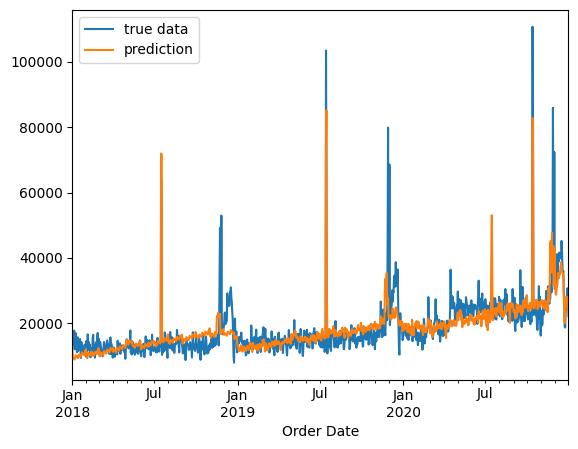

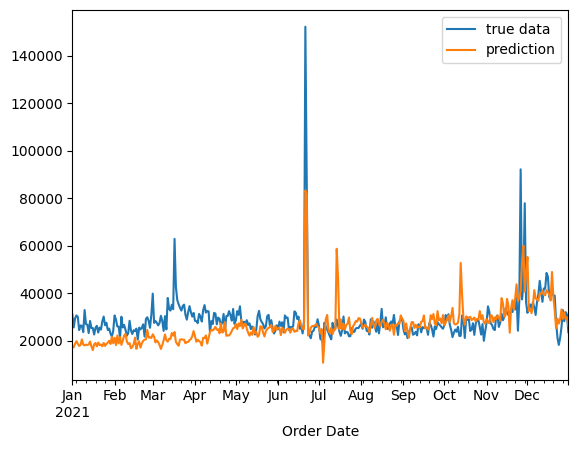

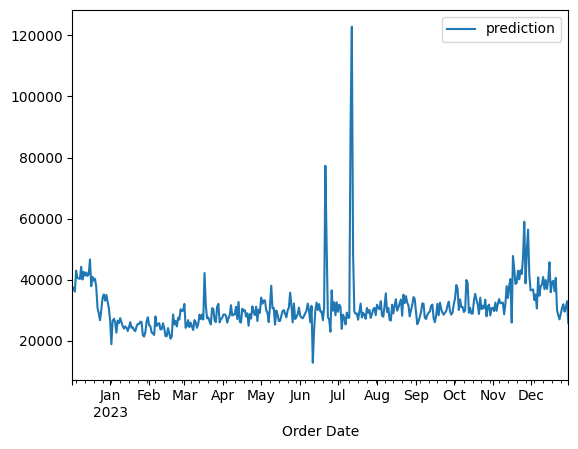

test:  8713.797605119733
[0]	validation_0-rmse:21286.51178	validation_1-rmse:27443.03452
[1]	validation_0-rmse:19489.25693	validation_1-rmse:25238.14240
[2]	validation_0-rmse:17902.02922	validation_1-rmse:23294.40697
[3]	validation_0-rmse:16503.32123	validation_1-rmse:21587.98608
[4]	validation_0-rmse:15273.63677	validation_1-rmse:20092.48247
[5]	validation_0-rmse:14192.59130	validation_1-rmse:18790.48622
[6]	validation_0-rmse:13248.10854	validation_1-rmse:17658.53863
[7]	validation_0-rmse:12423.34316	validation_1-rmse:16681.95656
[8]	validation_0-rmse:11708.93941	validation_1-rmse:15841.75181
[9]	validation_0-rmse:11091.65628	validation_1-rmse:15122.99432
[10]	validation_0-rmse:10560.24245	validation_1-rmse:14511.96315
[11]	validation_0-rmse:10102.18166	validation_1-rmse:13991.92633
[12]	validation_0-rmse:9710.44068	validation_1-rmse:13553.41276
[13]	validation_0-rmse:9376.09234	validation_1-rmse:13183.18234
[14]	validation_0-rmse:9090.26378	validation_1-rmse:12872.92528
[15]	validati

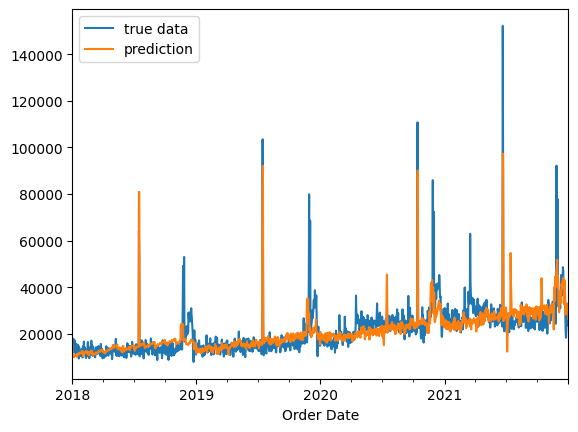

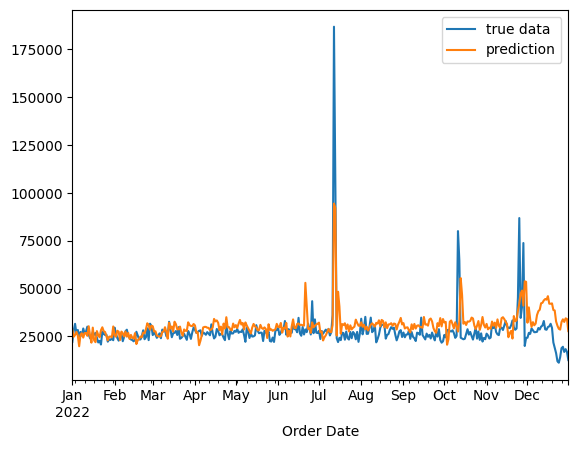

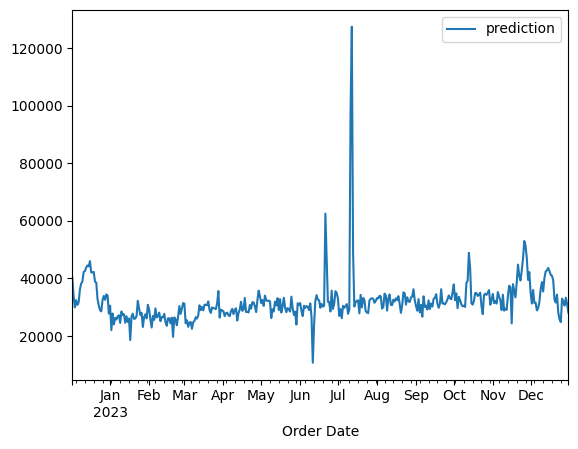

test:  9540.792716714202


In [64]:
preds, scores, feature_importances = cross_validate(df, forcast_df, feature_columns)

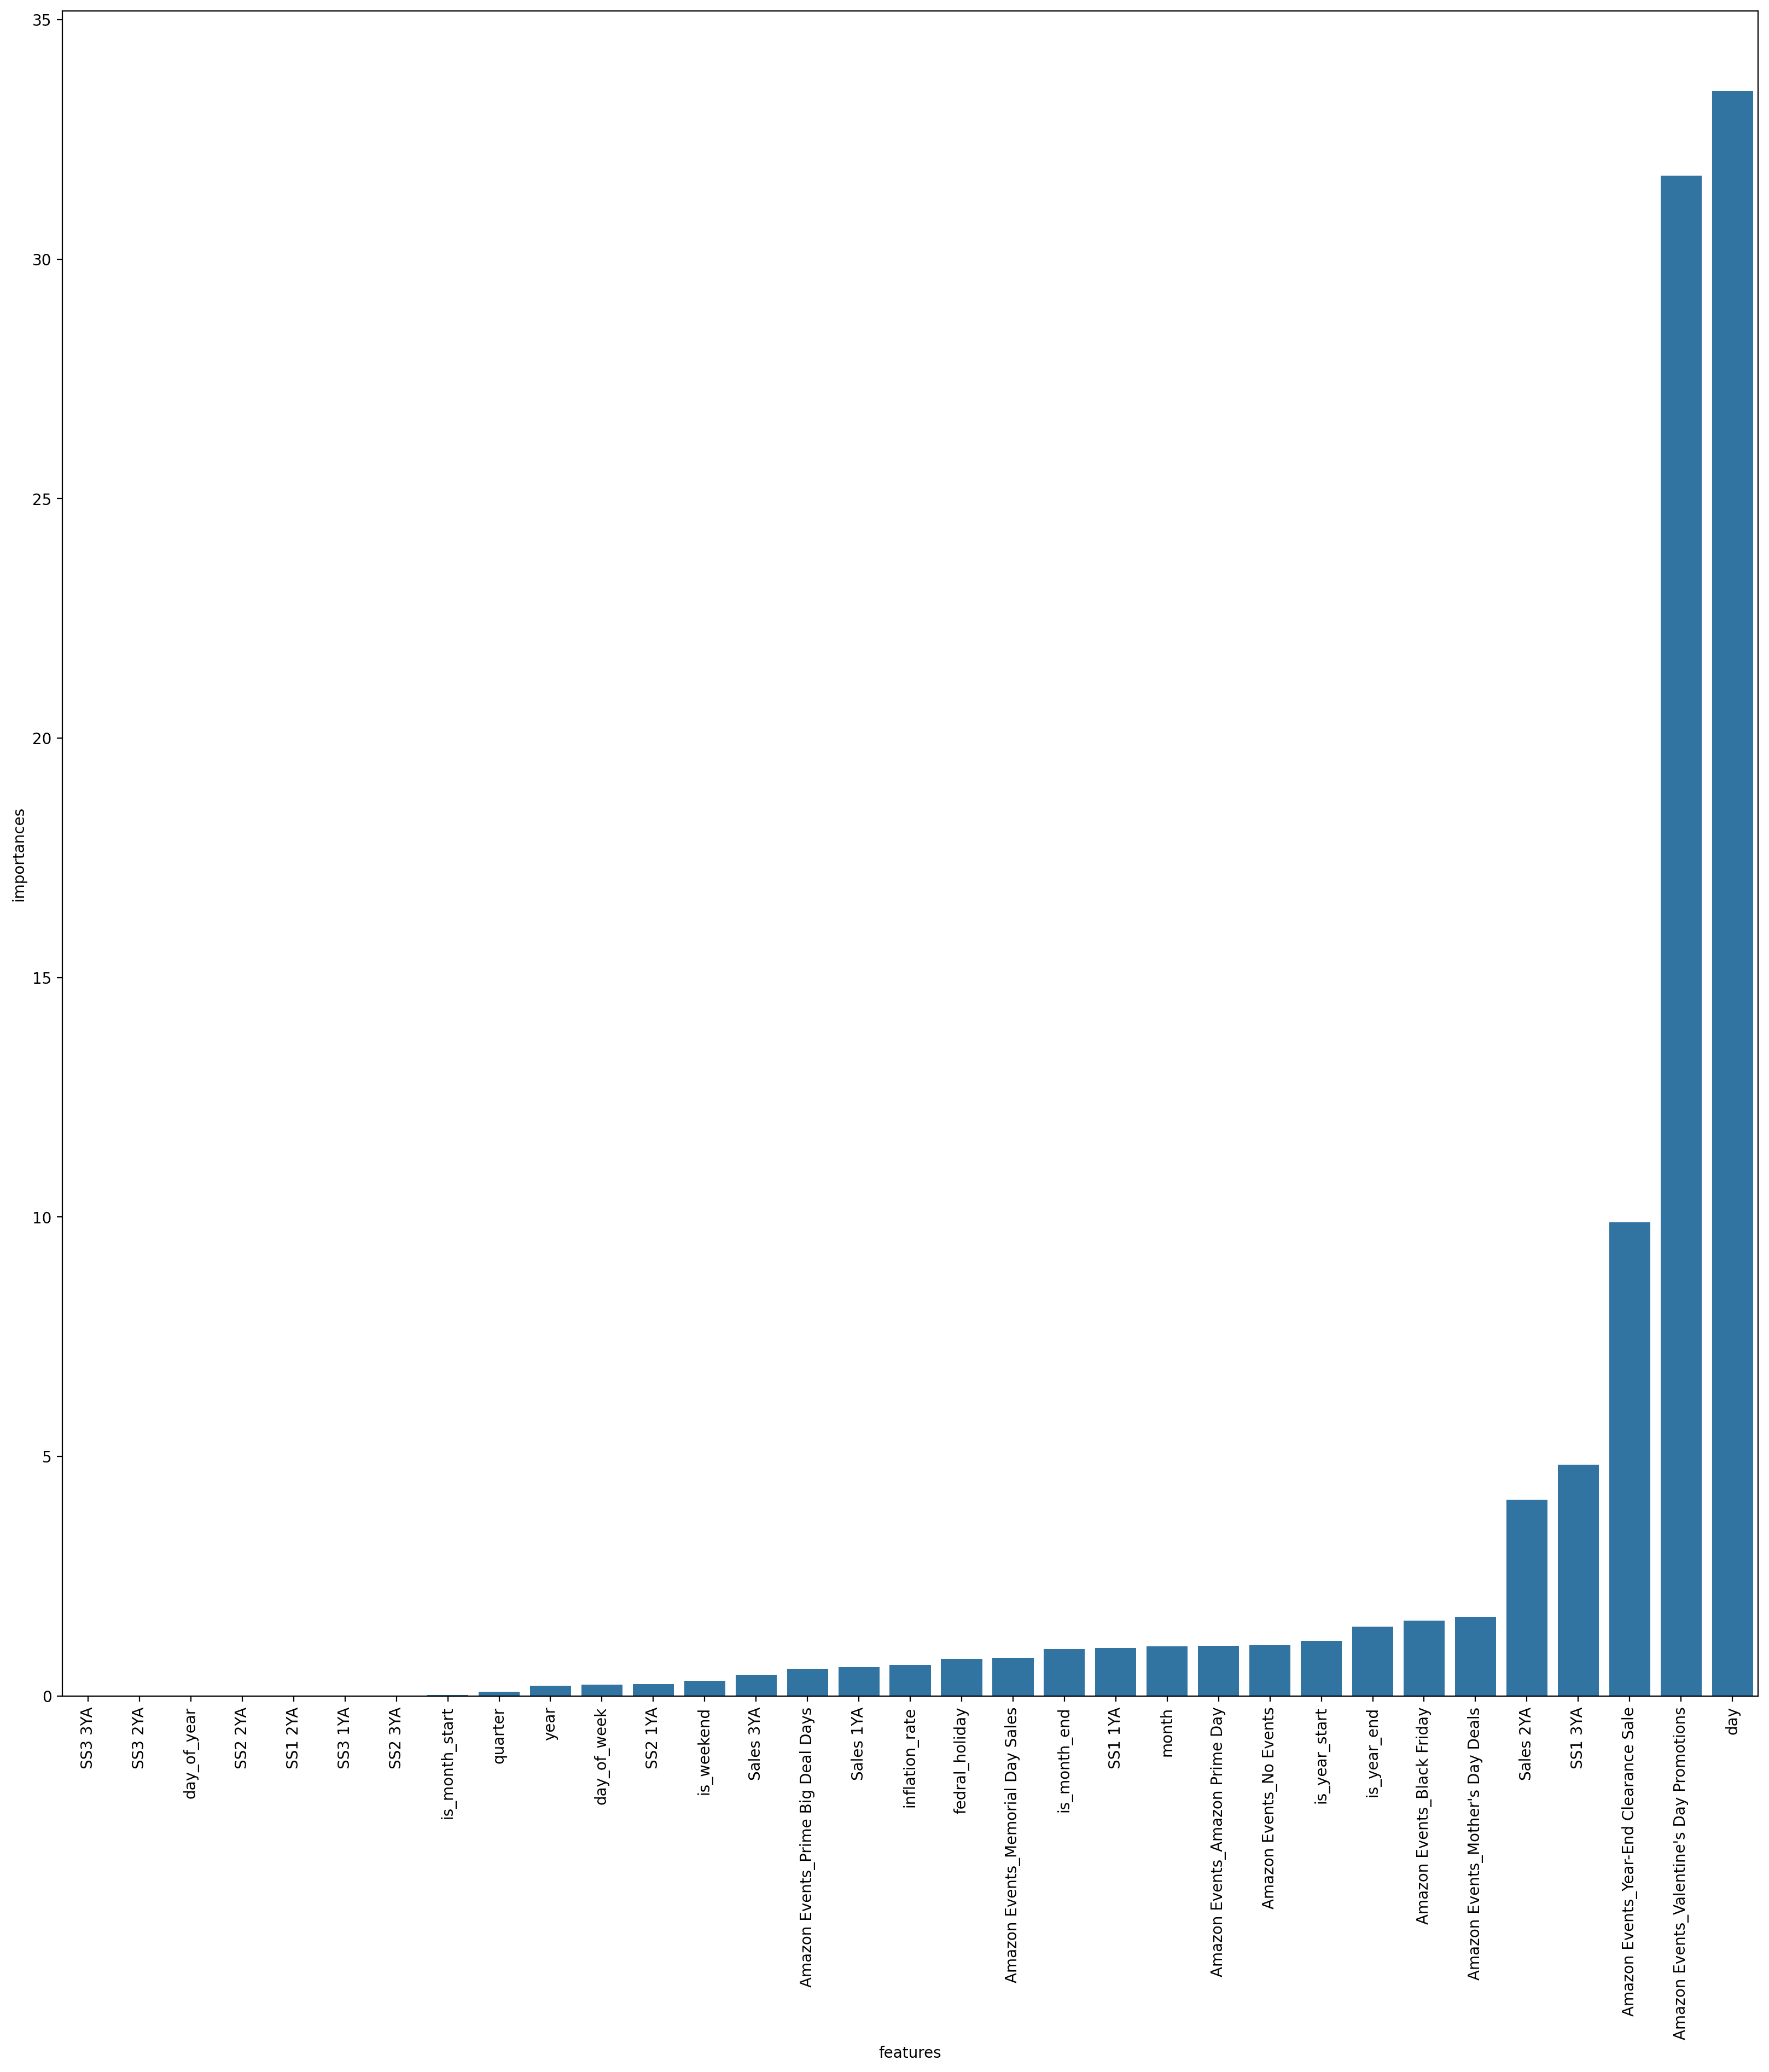

In [53]:
feature_importances_df = pd.DataFrame([feature_columns, feature_importances[-1]*100]).transpose().sort_values(by=1).rename(columns={0:'features',1:'importances'})

plt.figure(figsize=(20,20), dpi=200)
sns.barplot(feature_importances_df, x = 'features', y = 'importances')
plt.xticks(rotation=90);

In [54]:
int(np.sum(preds[0]))

6410402

## XGBOOST Train with full data

In [55]:
scores = []
for i in range(1000):
    reg_model = xgb.XGBRegressor(base_score=0.5, booster='gblinear',  n_estimators=i, early_stopping_rounds=50, objective='reg:squarederror', learning_rate=0.01)
    reg_model.fit(df[feature_columns], df['total_sales'], eval_set=[(df[feature_columns], df['total_sales'])], verbose=False)
    y_preds = reg_model.predict(df[feature_columns])
    scores.append(np.sqrt(mean_squared_error(df['total_sales'], y_preds)))
    

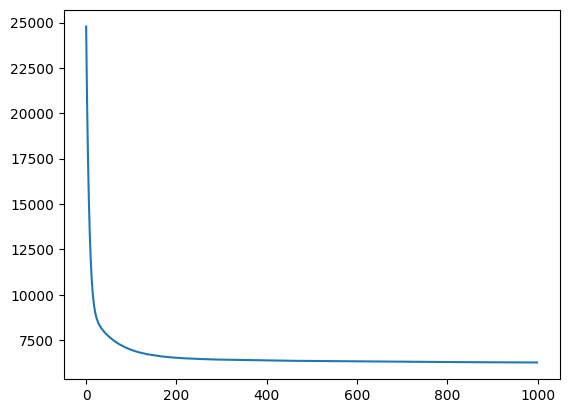

In [56]:
plt.plot(range(1000),scores)

In [57]:
scores[400:]

[np.float64(6374.965908550386),
 np.float64(6374.715140657594),
 np.float64(6374.4709074214725),
 np.float64(6373.939785274374),
 np.float64(6373.536706190039),
 np.float64(6373.342264636992),
 np.float64(6372.947992905537),
 np.float64(6372.524911469348),
 np.float64(6372.127686423257),
 np.float64(6371.830631449345),
 np.float64(6371.525035654685),
 np.float64(6370.798544554597),
 np.float64(6370.807244637683),
 np.float64(6368.142108846003),
 np.float64(6370.138476672374),
 np.float64(6369.587217321131),
 np.float64(6368.972809924169),
 np.float64(6368.69989777866),
 np.float64(6367.822934021289),
 np.float64(6368.206527645821),
 np.float64(6367.814348460745),
 np.float64(6367.717962748952),
 np.float64(6367.176433375279),
 np.float64(6366.667279837056),
 np.float64(6366.765364297513),
 np.float64(6366.236680895148),
 np.float64(6365.745220363884),
 np.float64(6365.6851935814),
 np.float64(6365.485372707566),
 np.float64(6364.8935038527925),
 np.float64(6364.579066256987),
 np.float

In [58]:
reg_model = xgb.XGBRegressor(base_score=0.5, booster='gblinear',  n_estimators=400, early_stopping_rounds=50, objective='reg:squarederror', learning_rate=0.01)
reg_model.fit(df[feature_columns], df['total_sales'], eval_set=[(df[feature_columns], df['total_sales'])], verbose=False)

XGBRegressor(base_score=0.5, booster='gblinear', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=400,
             n_jobs=None, num_parallel_tree=None, ...)

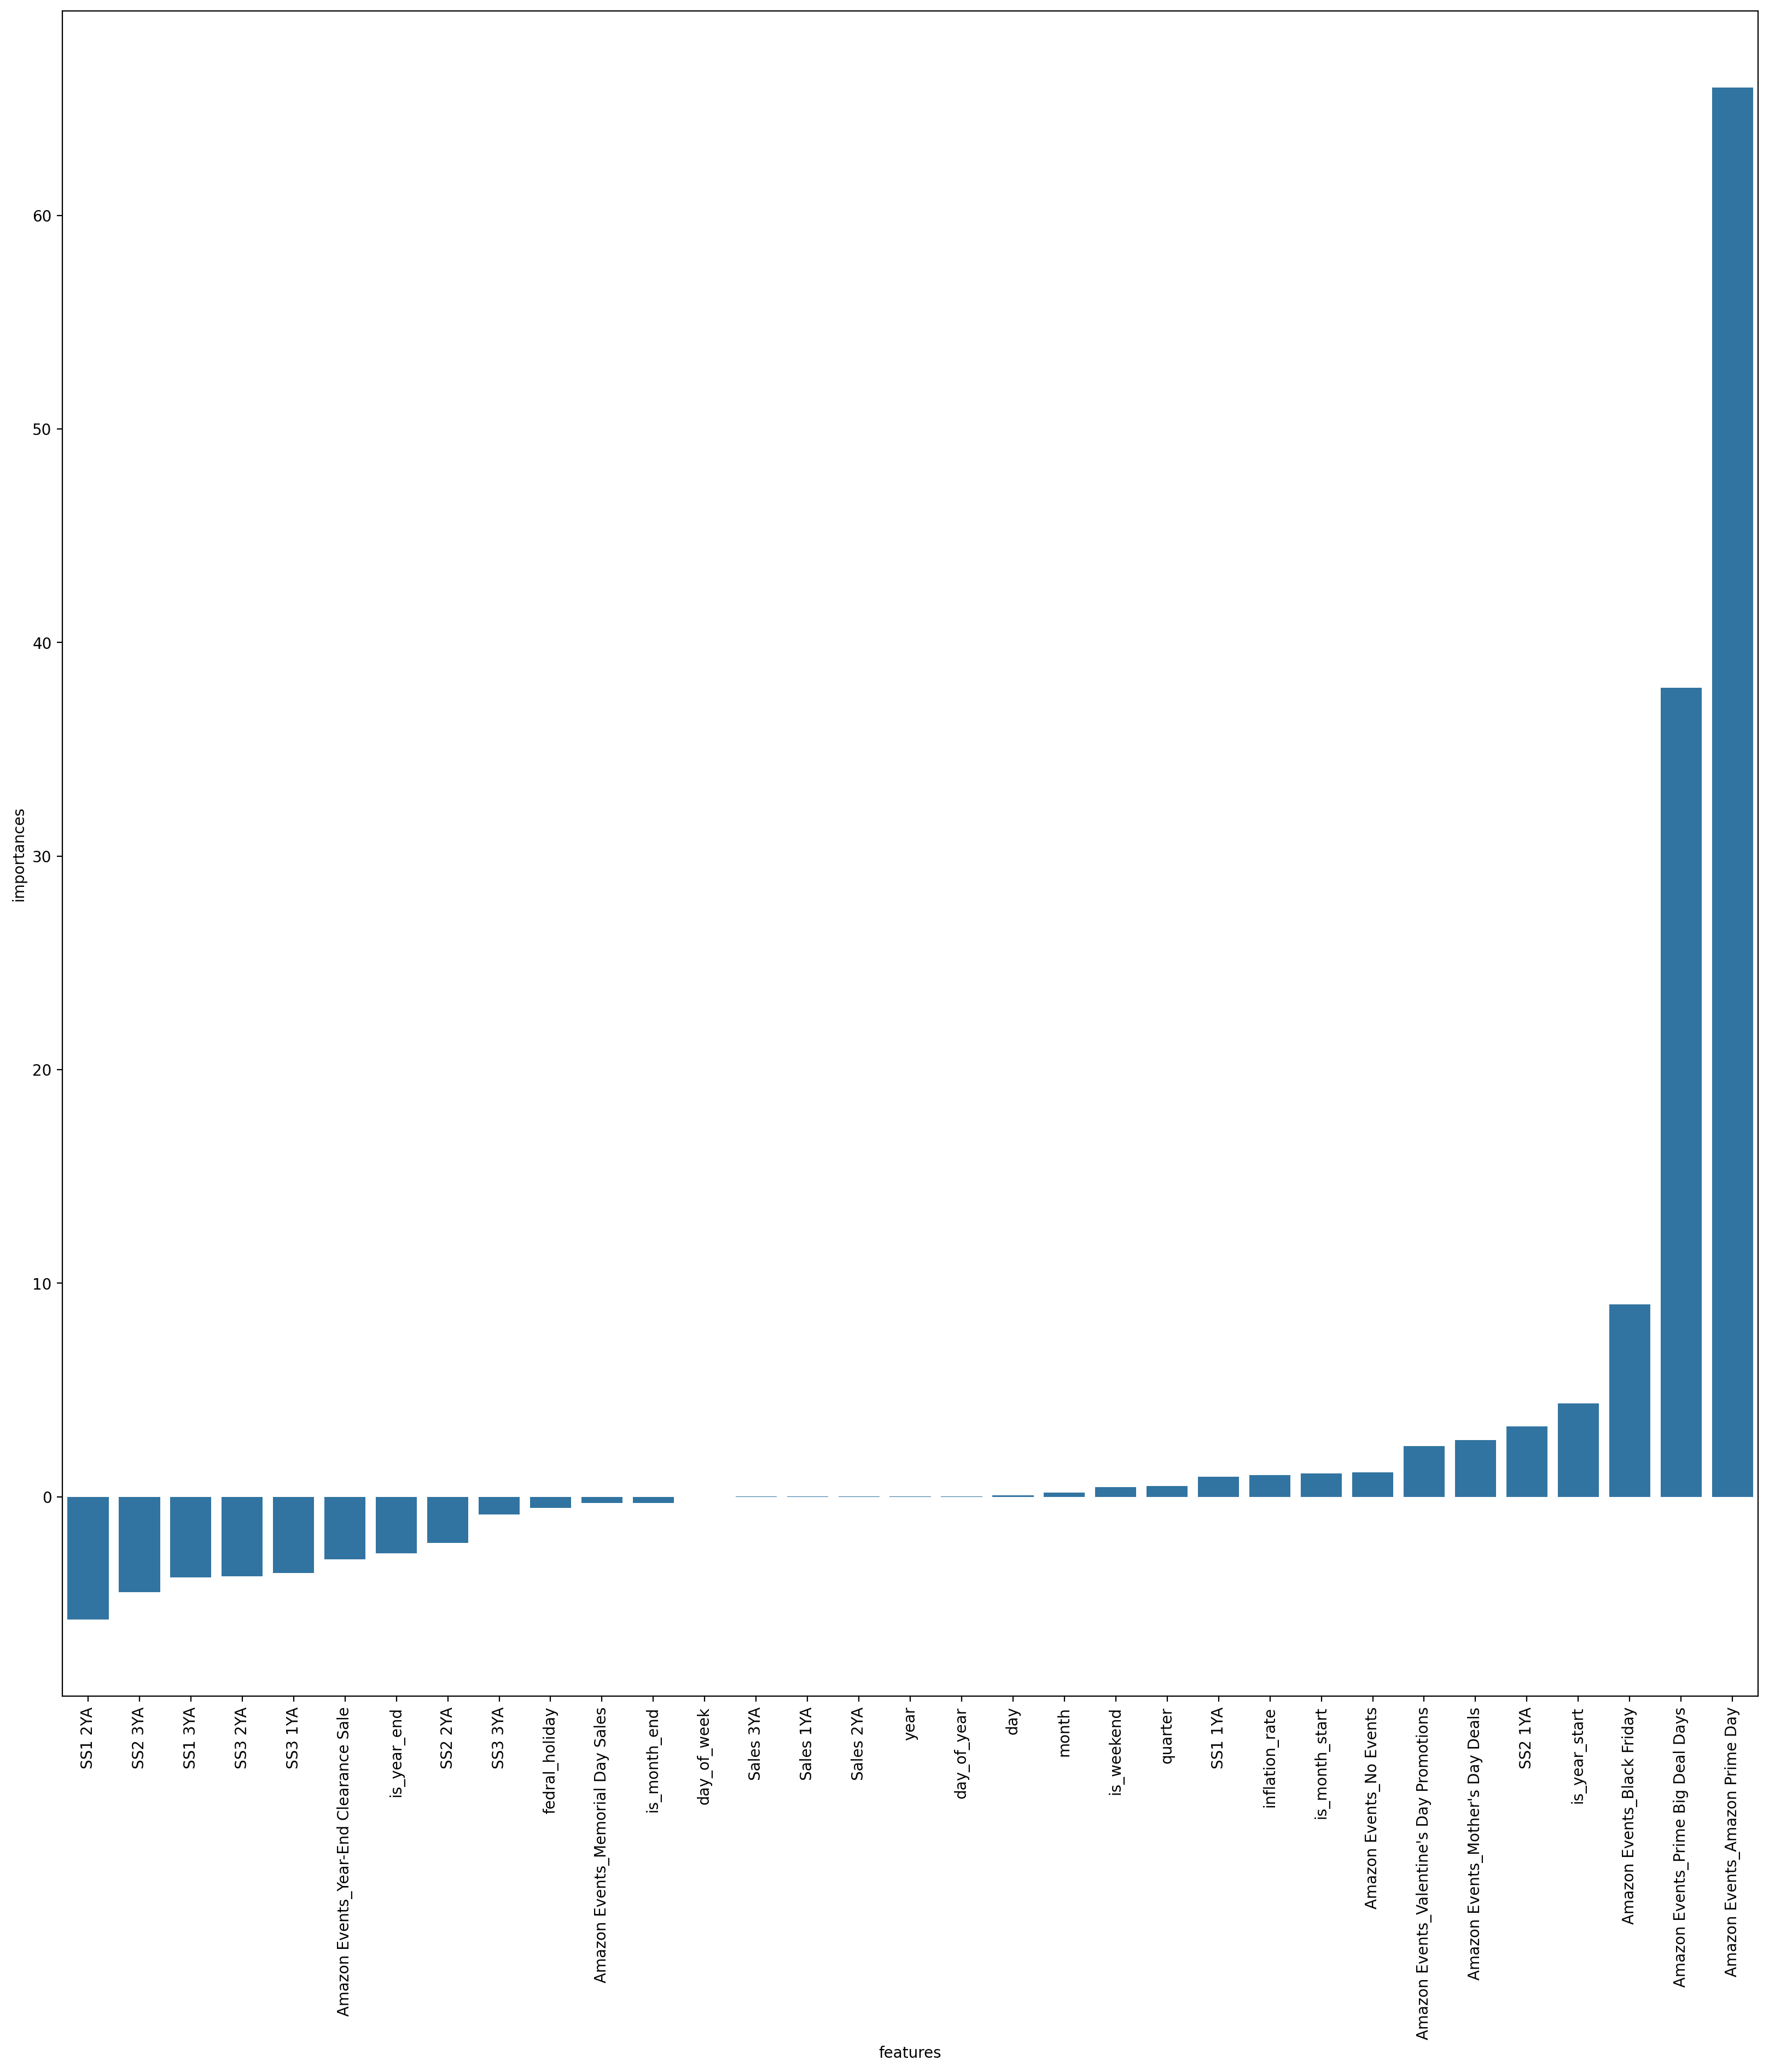

In [59]:
feature_importances_df = pd.DataFrame([feature_columns, reg_model.feature_importances_*100]).transpose().sort_values(by=1).rename(columns={0:'features',1:'importances'})

plt.figure(figsize=(20,20), dpi=200)
sns.barplot(feature_importances_df, x = 'features', y = 'importances')
plt.xticks(rotation=90);

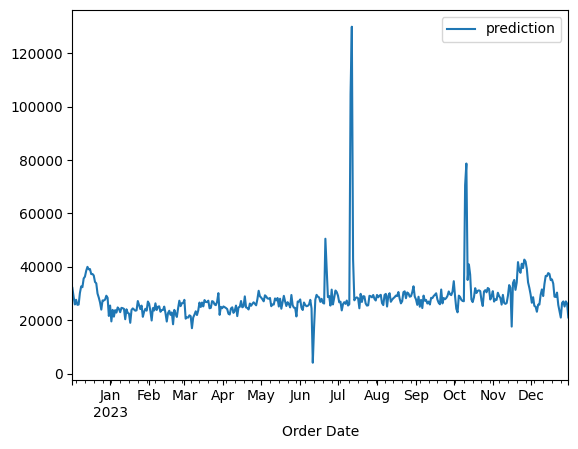

In [60]:
y_preds = reg_model.predict(forcast_df[feature_columns])
ds =  pd.Series(y_preds, index=forcast_df.index)
ds.plot(label='prediction')
plt.legend()
plt.show()

In [67]:
from catboost import CatBoostRegressor

In [133]:
def cross_validate(df, forcastdf, feature_columns):
    feature_importances = []
    tss = TimeSeriesSplit(n_splits=3, test_size=365, gap=0)
    param_grid = {'depth':[3], 'l2_leaf_reg':[2] ,'learning_rate':[0.01, 0.05],'n_estimators':[600, 800, 1000, 2000]}
    feature_columns = sorted(feature_columns)
    for train_idx, val_idx in tss.split(df):
        scaler = StandardScaler()
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        X_train = train[feature_columns]
        y_train = train['total_sales']
        X_test = test[feature_columns]
        y_test = test['total_sales']
        reg_model = GridSearchCV(CatBoostRegressor(silent=True), param_grid, scoring='neg_root_mean_squared_error')
        # reg_model = CatBoostRegressor(depth= 3, l2_leaf_reg= 2, learning_rate= 0.01, n_estimators= 800, silent=True)
        reg_model.fit(X_train, y_train,early_stopping_rounds=50)
        print(reg_model.best_params_)
        y_preds = reg_model.predict(X_train)
        score = np.sqrt(mean_squared_error(y_train, y_preds))
        print('training error: ',score)
        ds =  pd.concat([y_train.reset_index(),pd.Series(y_preds)], axis=1)
        ds = ds.set_index('Order Date')
        ds['total_sales'].plot(label='true data')
        ds[0].plot(label='prediction')
        plt.legend()
        plt.show()
        y_preds = reg_model.predict(X_test)
        score = np.sqrt(mean_squared_error(y_test, y_preds))
        print('test error: ',score)
        ds =  pd.concat([y_test.reset_index(),pd.Series(y_preds)], axis=1)
        ds = ds.set_index('Order Date')
        ds['total_sales'].plot(label='true data')
        ds[0].plot(label='prediction')
        plt.legend()
        plt.show()
        forcast_preds = reg_model.predict(forcastdf[feature_columns])
        ds =  pd.Series(forcast_preds, index=forcastdf.index)
        ds.plot(label='prediction')
        plt.legend()
        plt.show()
        preds.append(y_preds)

    return feature_importances

{'depth': 3, 'l2_leaf_reg': 2, 'learning_rate': 0.01, 'n_estimators': 1000}
training error:  2553.7420312053832


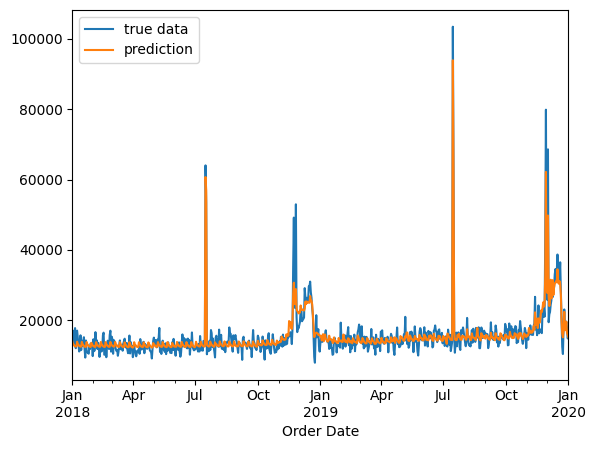

test error:  8637.648181174023


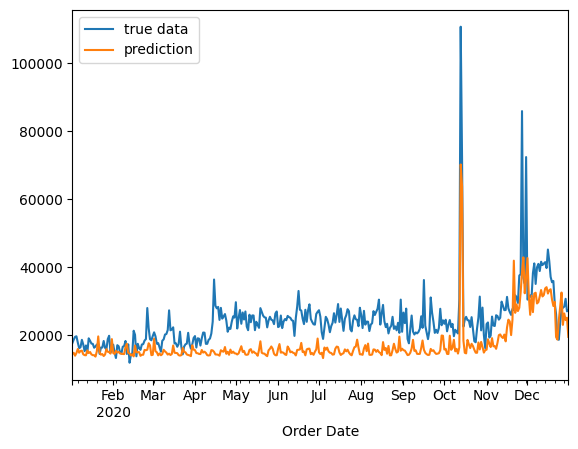

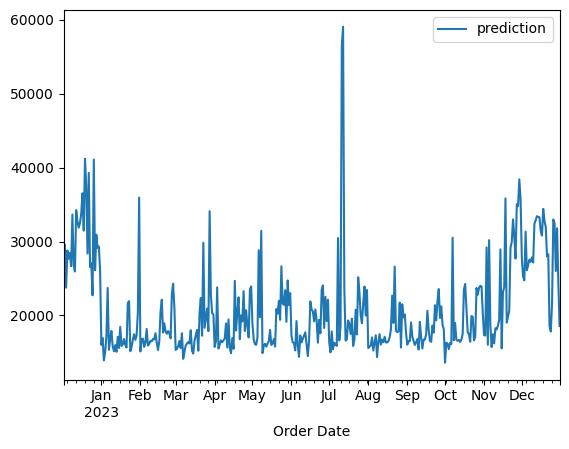

{'depth': 3, 'l2_leaf_reg': 2, 'learning_rate': 0.01, 'n_estimators': 2000}
training error:  2518.8665829467495


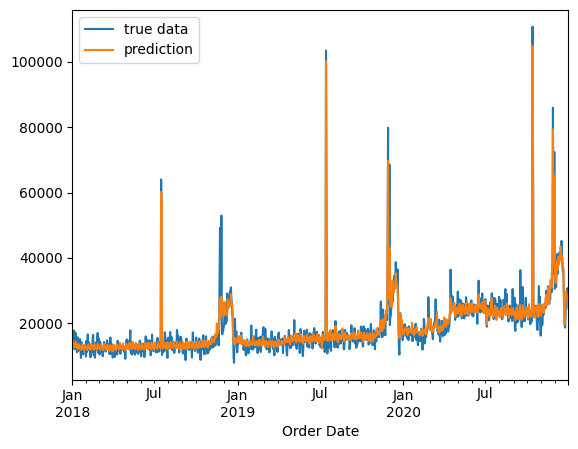

test error:  8089.075081080994


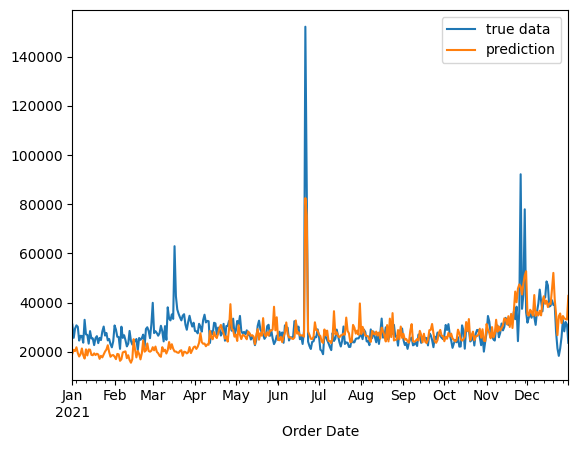

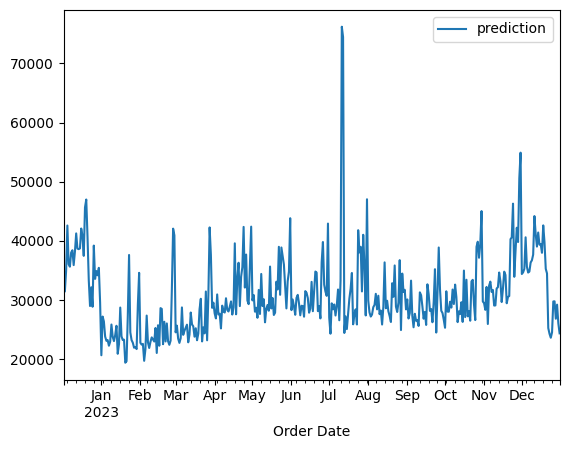

{'depth': 3, 'l2_leaf_reg': 2, 'learning_rate': 0.01, 'n_estimators': 1000}
training error:  3685.4683753066906


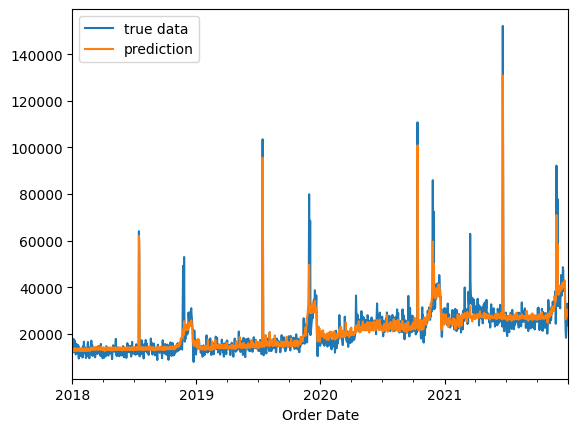

test error:  8586.44755928811


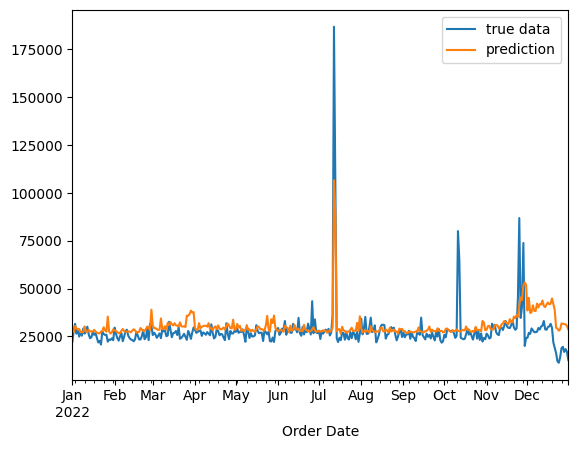

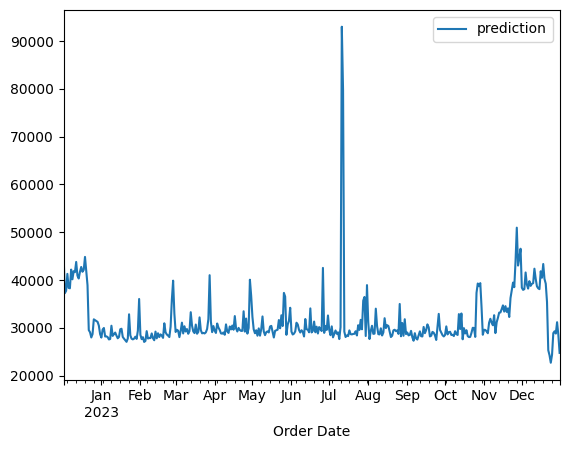

[]

In [134]:
cross_validate(df, forcast_df, feature_columns)

# Train Catboost with full data

In [131]:
reg_model = CatBoostRegressor(depth= 3, l2_leaf_reg= 2, learning_rate= 0.01, n_estimators= 1000, silent=True)
reg_model.fit(df[sorted(feature_columns)], df['total_sales'])

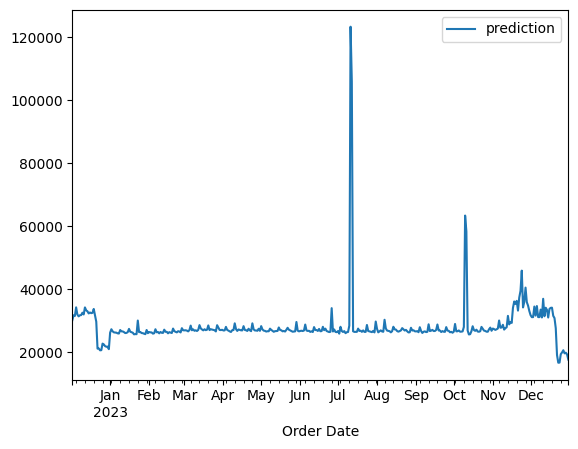

In [132]:
y_preds = reg_model.predict(forcast_df[sorted(feature_columns)])
ds =  pd.Series(y_preds, index=forcast_df.index)
ds.plot(label='prediction')
plt.legend()
plt.show()

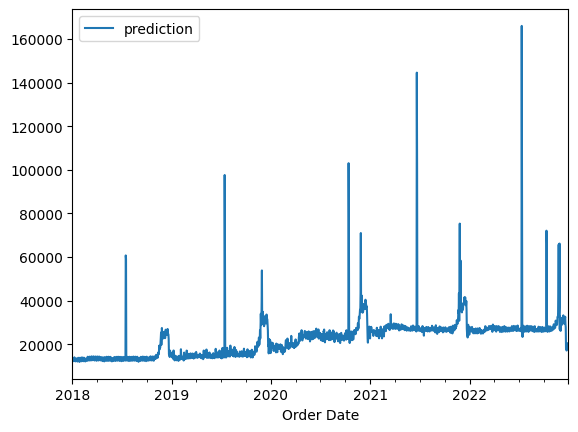

In [119]:
y_preds = reg_model.predict(df[sorted(feature_columns)])
ds =  pd.Series(y_preds, index=df.index)
ds.plot(label='prediction')
plt.legend()
plt.show()